In [1]:
import torch
import pandas
from transformers import BertModel, BertConfig, AdamW, BertTokenizer, BertForSequenceClassification
device = torch.device("cuda:0")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name()

'GeForce GTX 1080'

https://mccormickml.com/2019/07/22/BERT-fine-tuning/

https://nyu-mll.github.io/CoLA/

https://medium.com/swlh/painless-fine-tuning-of-bert-in-pytorch-b91c14912caa

https://www.groundai.com/project/fine-tune-bert-for-extractive-summarization/1

In [10]:
df=pandas.read_csv('../train/spacy_gold_lowercase_entity_labels.csv',sep=',')
df.columns=["islocation","isperson","goldlocation","goldperson","sentence"]
df = df.head(100)
df.islocation = df.islocation.astype(int)
df.isperson = df.isperson.astype(int)
df

,islocation,isperson,goldlocation,goldperson,sentence
0,0,0,NaN,NaN,this feature-length special consists of three ...
1,0,1,NaN,NaN,"in a mysterious and remote snowy outpost, matt..."
2,0,1,NaN,NaN,matt is a charismatic american trying to bring...
3,0,0,NaN,NaN,but are both men who they appear to be?
4,0,0,NaN,NaN,a woman gets thrust into a nightmarish world o...
5,0,0,NaN,NaN,plus a look at what would happen if you could ...
6,0,0,NaN,1.0,"raj is a rich, carefree, happy-go-lucky second..."
7,0,1,NaN,NaN,simran is the daughter of chaudhary baldev sin...
8,1,1,NaN,NaN,simran has left for india to be married to her...
9,1,0,NaN,1.0,raj leaves for india with a mission at his han...


In [13]:
# Create sentence and label lists
from math import isnan
sentences = df.sentence.values
labels = []
for idx,row in df.iterrows():
    label = row.islocation
    if not isnan(row.goldlocation):
        label = int(row.goldlocation)
    labels.append(label)

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

In [16]:
print(labels[:10])
print(sentences[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
['[CLS] this feature-length special consists of three interwoven stories. [SEP]', '[CLS] in a mysterious and remote snowy outpost, matt and potter share a christmas meal, swapping creepy tales of their earlier lives in the outside world. [SEP]', '[CLS] matt is a charismatic american trying to bring the reserved, secretive potter out of his shell. [SEP]', '[CLS] but are both men who they appear to be? [SEP]', "[CLS] a woman gets thrust into a nightmarish world of 'smart' gadgetry. [SEP]", "[CLS] plus a look at what would happen if you could 'block' people in real life. [SEP]", '[CLS] raj is a rich, carefree, happy-go-lucky second generation nri. [SEP]', '[CLS] simran is the daughter of chaudhary baldev singh, who in spite of being an nri is very strict about adherence to indian values. [SEP]', '[CLS] simran has left for india to be married to her childhood fiancé. [SEP]', '[CLS] raj leaves for india with a mission at his hands, to claim his lady love under

In [17]:
pretrained_weights = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights, do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'this', 'feature', '-', 'length', 'special', 'consists', 'of', 'three', 'inter', '##wo', '##ven', 'stories', '.', '[SEP]']


In [18]:
maxlen = max(map(lambda x: len(x),sentences))
maxlen

264

In [19]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [20]:
# Pad our input tokens
from keras_preprocessing.sequence import pad_sequences
input_ids = pad_sequences(input_ids, maxlen=maxlen, dtype="long", truncating="post", padding="post")

In [21]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [22]:
# Use train_test_split to split our data into train and validation sets for training
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [23]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 12

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [25]:
model = BertForSequenceClassification.from_pretrained(pretrained_weights, num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [26]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [27]:
from transformers import WarmupLinearSchedule
lr=2e-5
max_grad_norm = 1.0
num_total_steps = 1000
num_warmup_steps = 100

# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=lr, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [28]:
import numpy as np
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
import io
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    scheduler.step()

    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      loss, logits = outputs[:2]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:  25%|██▌       | 1/4 [00:04<00:12,  4.12s/it]

Train loss: 0.7597161829471588
Validation Accuracy: 0.1


Epoch:  50%|█████     | 2/4 [00:07<00:07,  4.00s/it]

Train loss: 0.6992053464055061
Validation Accuracy: 1.0


Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.91s/it]

Train loss: 0.5777226239442825
Validation Accuracy: 1.0


Epoch: 100%|██████████| 4/4 [00:15<00:00,  3.86s/it]

Train loss: 0.476173335686326
Validation Accuracy: 1.0


In [30]:
print("Train loss: {}".format(tr_loss/nb_tr_steps))

Train loss: 0.476173335686326


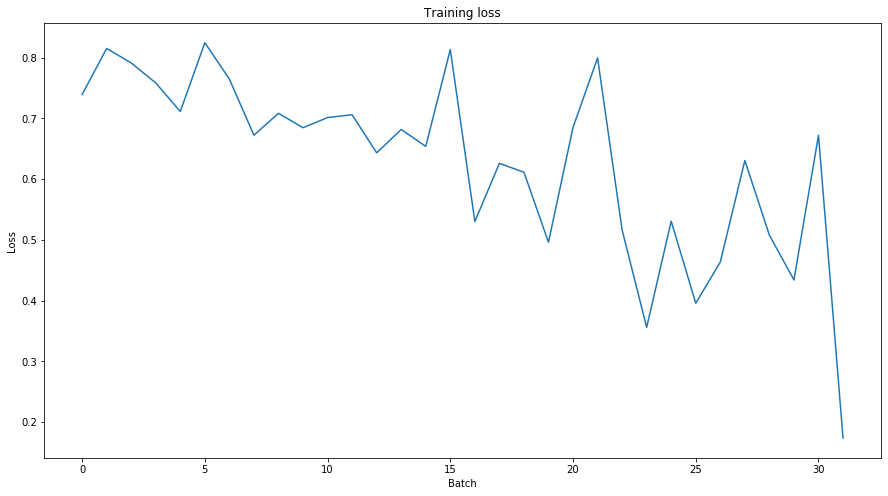

In [31]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [32]:
torch.save(model,'tmdb-bert-location-classifier.model')